# 未来1个周期的方向性预测

# 1.数据获取与预处理

通过API从某数字货币交易所获取了某数字货币合约最近的1681根30minK线，数据内容如下：

In [150]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [151]:
#use pandas to read the data
df = pd.read_csv('30min.csv')
df.head(5)

,timestamp,open,high,low,close,volume,volume_btc
0,1526617800000,12.631,12.696,12.490,12.546,162600.0,128981.202852
1,1526619600000,12.546,12.609,12.361,12.469,143098.0,114577.461021
2,1526621400000,12.450,12.552,12.445,12.533,179032.0,143161.416482
3,1526623200000,12.508,12.539,12.424,12.460,114788.0,92008.268142
4,1526625000000,12.454,12.460,12.237,12.259,211346.0,171079.276147


我们需要的数据是每根K线的open, high, low, close, volume，将多余的列去掉，并对每列进行归一化

In [152]:
#drop useless column and normalize data
df.drop(['volume_btc'], axis = 1, inplace = True)
def norm(df):
    for col in df.columns[1:]:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
norm(df)
df.head(5)

,timestamp,open,high,low,close,volume
0,1526617800000,0.503557,0.436671,0.508671,0.491144,0.015671
1,1526619600000,0.491215,0.424401,0.489048,0.479965,0.013792
2,1526621400000,0.477276,0.416361,0.501825,0.489257,0.017255
3,1526623200000,0.485698,0.414528,0.498631,0.478659,0.011063
4,1526625000000,0.477857,0.403385,0.470186,0.449477,0.020370


加入标签列，若下一周期收盘价高于当前周期收盘价，则记为1，表示上涨；相等则记为0；下跌记为-1

In [153]:
#add a label column
df['label'] = 0
for i in range(len(df) - 1):
    if df.loc[i + 1]['close'] > df.loc[i]['close']:
        df.loc[i, 'label'] = 1
    elif df.loc[i + 1]['close'] == df.loc[i]['close']:
        df.loc[i, 'label'] = 0
    else:
        df.loc[i, 'label'] = -1
df.head(10)

,timestamp,open,high,low,close,volume,label
0,1526617800000,0.503557,0.436671,0.508671,0.491144,0.015671,-1
1,1526619600000,0.491215,0.424401,0.489048,0.479965,0.013792,1
2,1526621400000,0.477276,0.416361,0.501825,0.489257,0.017255,-1
3,1526623200000,0.485698,0.414528,0.498631,0.478659,0.011063,-1
4,1526625000000,0.477857,0.403385,0.470186,0.449477,0.020370,1
5,1526626800000,0.450123,0.445839,0.472619,0.506969,0.057313,1
6,1526628600000,0.509801,0.478138,0.529054,0.519454,0.085445,1
7,1526630400000,0.519530,0.476305,0.546851,0.532520,0.180300,1
8,1526632200000,0.532452,0.465444,0.539702,0.533537,0.133235,-1
9,1526634000000,0.533904,0.457687,0.551110,0.528020,0.088566,-1


# 2.特征选择

原始K线数据包含太多噪音，不宜直接用做feature，在这里我们选用一些常见的技术指标作为feature，下面是我们要用到的技术指标及其计算方法：

### 移动平均线（MA）
移动平均线的计算公式为：$$MA(t) = \frac{\sum_{i=t-n}^{t}{close}}{n}$$
即周期为n的移动平均线第t个点值为前n根K线收盘价的平均值。
移动平均线能够在一定程度上反应当前的价格走势，我们分别计算5周期与20周期移动平均线，利用长短周期均线上点的值相对大小构造一个feature，短周期线上点的值大于长周期表明可能处于上升趋势，feature值为1；相等为0；短周期小于长周期则为-1

In [154]:
#add a feature column ma, use talib to calculate moving average line
import talib as tb
df.insert(6, 'ma', 0)
ma5 = tb.SMA(np.array(df['close']), 5)
ma20 = tb.SMA(np.array(df['close']), 20)
for i in range(20, len(df)):
    if ma5[i] > ma20[i]:
        df.loc[i, 'ma'] = 1
    elif ma5[i] == ma20[i]:
        df.loc[i, 'ma'] = 0
    else:
        df.loc[i, 'ma'] = -1
df.head(40)

,timestamp,open,high,low,close,volume,ma,label
0,1526617800000,0.503557,0.436671,0.508671,0.491144,0.015671,0,-1
1,1526619600000,0.491215,0.424401,0.489048,0.479965,0.013792,0,1
2,1526621400000,0.477276,0.416361,0.501825,0.489257,0.017255,0,-1
3,1526623200000,0.485698,0.414528,0.498631,0.478659,0.011063,0,-1
4,1526625000000,0.477857,0.403385,0.470186,0.449477,0.020370,0,1
5,1526626800000,0.450123,0.445839,0.472619,0.506969,0.057313,0,1
6,1526628600000,0.509801,0.478138,0.529054,0.519454,0.085445,0,1
7,1526630400000,0.519530,0.476305,0.546851,0.532520,0.180300,0,1
8,1526632200000,0.532452,0.465444,0.539702,0.533537,0.133235,0,-1
9,1526634000000,0.533904,0.457687,0.551110,0.528020,0.088566,0,-1


## 指数平滑异同移动平均线（MACD）
MACD也是一个重要的技术分析指标，其计算方法如下:  
首先计算出两个不同周期收盘价的指数移动平均（EMA）之间的差离值DIF：
$$DIF = EMA_{(close, 12)} - EMA_{(close, 26)}$$  
然后计算DIF的指数移动平均：
$$DEM = EMA_{(DIF, 9)}$$  
最后计算DIF与DEM的差值得到MACD指标中的柱状图的值  
$$hist = DIF - DEM$$  
这里我们使用hist值作为一个feature

In [155]:
#add macd_hist feature
dif, dem, hist = tb.MACD(np.array(df['close']), fastperiod = 12, slowperiod = 26, signalperiod = 9)
hist = np.nan_to_num(hist)
hist = (hist - hist.mean()) / (hist.max() - hist.min())
df.insert(7, 'macd_hist', hist)
df.head(40)

,timestamp,open,high,low,close,volume,ma,macd_hist,label
0,1526617800000,0.503557,0.436671,0.508671,0.491144,0.015671,0,0.000173,-1
1,1526619600000,0.491215,0.424401,0.489048,0.479965,0.013792,0,0.000173,1
2,1526621400000,0.477276,0.416361,0.501825,0.489257,0.017255,0,0.000173,-1
3,1526623200000,0.485698,0.414528,0.498631,0.478659,0.011063,0,0.000173,-1
4,1526625000000,0.477857,0.403385,0.470186,0.449477,0.020370,0,0.000173,1
5,1526626800000,0.450123,0.445839,0.472619,0.506969,0.057313,0,0.000173,1
6,1526628600000,0.509801,0.478138,0.529054,0.519454,0.085445,0,0.000173,1
7,1526630400000,0.519530,0.476305,0.546851,0.532520,0.180300,0,0.000173,1
8,1526632200000,0.532452,0.465444,0.539702,0.533537,0.133235,0,0.000173,-1
9,1526634000000,0.533904,0.457687,0.551110,0.528020,0.088566,0,0.000173,-1


## 随机指标（KDJ）
KDJ用于衡量超买与超卖程度，计算方法为：  
首先求出未成熟随机值（RSV）：  
$$RSV = \frac{C_n - L_n}{H_n - L_n} \times 100\%$$  
其中n为周期，一般取9；$C_n, L_n, H_n$分别为第n日收盘价、过去n日中最低价及最高价  
然后通过计算RSV的3日指数移动平均计算K值与D值：  
$$K_n = \alpha \times RSV_n + (1 - \alpha) \times RSV_{n - 1}$$  
$$D_n = \alpha \times K_N + (1 - \alpha) \times D_{n - 1}$$  
$$(\alpha = \frac{1}{3})$$  
最后J值计算：  
$$J_n = 3 \times D_n - 2 \times K_n$$
我们这里选用J值作为一个feature

In [156]:
#add kdj feature
k, d = tb.STOCH(np.array(df['high']), np.array(df['low']), np.array(df['close']))
j = 3 * d - 2 * k
j = np.nan_to_num(j)
j = (j - j.mean()) / (j.max() - j.min())
df.insert(8, 'kdj_j', j)
df.head(40)

,timestamp,open,high,low,close,volume,ma,macd_hist,kdj_j,label
0,1526617800000,0.503557,0.436671,0.508671,0.491144,0.015671,0,0.000173,-0.001135,-1
1,1526619600000,0.491215,0.424401,0.489048,0.479965,0.013792,0,0.000173,-0.001135,1
2,1526621400000,0.477276,0.416361,0.501825,0.489257,0.017255,0,0.000173,-0.001135,-1
3,1526623200000,0.485698,0.414528,0.498631,0.478659,0.011063,0,0.000173,-0.001135,-1
4,1526625000000,0.477857,0.403385,0.470186,0.449477,0.020370,0,0.000173,-0.001135,1
5,1526626800000,0.450123,0.445839,0.472619,0.506969,0.057313,0,0.000173,-0.001135,1
6,1526628600000,0.509801,0.478138,0.529054,0.519454,0.085445,0,0.000173,-0.001135,1
7,1526630400000,0.519530,0.476305,0.546851,0.532520,0.180300,0,0.000173,-0.001135,1
8,1526632200000,0.532452,0.465444,0.539702,0.533537,0.133235,0,0.000173,-0.003899,-1
9,1526634000000,0.533904,0.457687,0.551110,0.528020,0.088566,0,0.000173,0.004611,-1


最后再对每根K线的四个值求平均得到一个feature

In [157]:
#add feature mean
mean = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df.insert(9, 'mean', mean)
df.head(30)

,timestamp,open,high,low,close,volume,ma,macd_hist,kdj_j,mean,label
0,1526617800000,0.503557,0.436671,0.508671,0.491144,0.015671,0,0.000173,-0.001135,0.485011,-1
1,1526619600000,0.491215,0.424401,0.489048,0.479965,0.013792,0,0.000173,-0.001135,0.471157,1
2,1526621400000,0.477276,0.416361,0.501825,0.489257,0.017255,0,0.000173,-0.001135,0.471180,-1
3,1526623200000,0.485698,0.414528,0.498631,0.478659,0.011063,0,0.000173,-0.001135,0.469379,-1
4,1526625000000,0.477857,0.403385,0.470186,0.449477,0.020370,0,0.000173,-0.001135,0.450226,1
5,1526626800000,0.450123,0.445839,0.472619,0.506969,0.057313,0,0.000173,-0.001135,0.468888,1
6,1526628600000,0.509801,0.478138,0.529054,0.519454,0.085445,0,0.000173,-0.001135,0.509112,1
7,1526630400000,0.519530,0.476305,0.546851,0.532520,0.180300,0,0.000173,-0.001135,0.518801,1
8,1526632200000,0.532452,0.465444,0.539702,0.533537,0.133235,0,0.000173,-0.003899,0.517784,-1
9,1526634000000,0.533904,0.457687,0.551110,0.528020,0.088566,0,0.000173,0.004611,0.517680,-1


# 3.构建模型，训练、验证

这里使用TensorFlow来构建下面这些常见的机器学习/深度学习模型，看看各模型在此数据集上效果如何
## Logistic Regression
选用mean, volume, ma, macd_hist, kdj_j作为feature，首先划分数据集，前1200根K线作为训练数据集，后481根作为验证集

In [182]:
#split dataset
#training set
train_feature = pd.DataFrame()
train_feature.insert(0, 'mean', df['mean'][:1200])
train_feature.insert(1, 'volume', df['volume'][:1200])
train_feature.insert(2, 'ma', df['ma'][:1200])
train_feature.insert(3, 'macd_hist', df['macd_hist'][:1200])
train_feature.insert(4, 'kdj_j', df['kdj_j'][:1200])
#one-hot representation of labels
train_label = pd.DataFrame(data = np.zeros([1200, 3]), index = list(range(1200)), columns = list(['-1', '0', '1']))
for i in range(1200):
    if df.loc[i, 'label'] == -1:
        train_label.loc[i, '-1'] = 1
    elif df.loc[i, 'label'] == 0:
        train_label.loc[i, '0'] = 1
    else:
        train_label.loc[i, '1'] = 1

#test set
test_feature = pd.DataFrame(df['mean'][1200:])
test_feature.insert(1, 'volume', df['volume'][1200:])
test_feature.insert(2, 'ma', df['ma'][1200:])
test_feature.insert(3, 'macd_hist', df['macd_hist'][1200:])
test_feature.insert(4, 'kdj_j', df['kdj_j'][1200:])
#one-hot representation of test labels
test_label = pd.DataFrame(data = np.zeros([481, 3]), index = list(range(481)), columns = list(['-1', '0', '1']))
for i in range(1200, 1681):
    if df.loc[i, 'label'] == -1:
        test_label.loc[i - 1200, '-1'] = 1
    elif df.loc[i, 'label'] == 0:
        test_label.loc[i - 1200, '0'] = 1
    else:
        test_label.loc[i - 1200, '1'] = 1

#get next batch
def next_batch(batch_num, batch_size):
    batch_xs = np.array(train_feature[batch_num * batch_size : (batch_num + 1) * batch_size])
    batch_ys = np.array(train_label[batch_num * batch_size : (batch_num + 1) * batch_size])
    return batch_xs, batch_ys

[0.54677755, 0.54677755, 0.54677755, 0.54677755, 0.54885656]


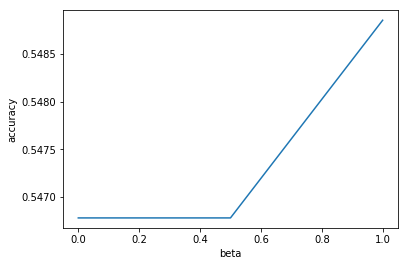

In [232]:
#logistic regression

#model definition, traing and testing
def logistic(learning_rate, epochs, beta, batch_size):
    #graph input
    x = tf.placeholder(tf.float32, [None, 5]) #feature vector 1 x 5
    y = tf.placeholder(tf.float32, [None, 3]) #label, 3 classes

    #model weights
    w = tf.Variable(tf.zeros([5, 3]))
    b = tf.Variable(tf.zeros([3]))

    #model
    pred = tf.nn.softmax(tf.matmul(x, w) + b)

    #cross entropy loss
    loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred), reduction_indices = 1))
    regularizer = tf.nn.l2_loss(w)
    loss = tf.reduce_mean(loss + beta * regularizer)
    #gradient descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    #init variables
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)

        #training
        for epoch in range(epochs):
            avg_loss = 0
            total_batch = int(len(train_feature) / batch_size)
            for i in range(total_batch):
                batch_xs, batch_ys = next_batch(i, batch_size)
                _, c = sess.run([optimizer, loss], feed_dict = {x: batch_xs, y: batch_ys})
                avg_loss += c / total_batch
            #if (epoch + 1) % display_step == 0:
            #    print("epoch: %d, loss = %f" % (epoch + 1, avg_loss))
        #print("Training Finished.")
        #print(sess.run(w))
        #print(sess.run(b))

        #test
        correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        return accuracy.eval({x: np.array(test_feature), y: np.array(test_label)})
        #print("Accuracy: ", accuracy.eval({x: np.array(test_feature), y: np.array(test_label)}))


#hyper parameters
display_step = 1
learning_rate = [0.01, 0.03, 0.05, 0.07, 0.1]
epochs = [10, 30, 50, 70, 100]
batch_size = [10, 30, 50, 60, 100]
#regularize parameter
beta = [0, 0.1, 0.3, 0.5, 1]

#fix learinig_rate = 0.01, epoch = 50, batch_size = 100 to see the effect of l2_regularization
accuracy = []
for i in beta:
    accuracy.append(logistic(0.01, 50, i, 100))        

print(accuracy)
plt.xlabel('beta')
plt.ylabel('accuracy')
plt.plot(beta, accuracy)
plt.show()

加入正则化项可以降低模型复杂度，避免过拟合，对提高模型的泛化性能有好处。
训练的epochs也不宜太大，否则容易造成过拟合导致模型在验证集上效果很差。